In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling1D

In [2]:
"""
Data Load
"""

import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

directory1 = "C:/Users/windows10/ys_PyProject/apg 파일/"
data = []

# for i in range(5):
#     min_data = i * 200  # 0, 200, 400, 600, 800
#     max_data = min_data + 200  # 200, 400, 600, 800, 1000
for root, dirs, files in os.walk(directory1):
#     files.sort()
    for file in files:
        if file.endswith(".csv"):
            full_path = os.path.join(root, file)
            df = pd.read_csv(full_path, usecols=['APG Wave'])
            series = df.values.flatten()[:200]  # max data
            series = series.reshape(-1, 1)  # 1D -> 2D
            scaler = MinMaxScaler()
            series = scaler.fit_transform(series)
            data.append(series)

data_array = np.array(data)

# y를 적절하게 수정 필요 (클래스 불균형 고려)

print("Shape of data_array:", data_array.shape)

import pandas as pd

# 엑셀 파일 불러오기 (엑셀 파일의 경로를 넣어야 합니다)
df = pd.read_csv("2024-10-11 (11-00-32)-APG【 이기장 】.csv")
df_sorted = df.sort_values(by='TestDate')

# 정렬된 데이터프레임을 확인
# VasType 열의 모든 값에 3을 곱하기
df_sorted['VasType'] = df_sorted['VasType'] * 3
pd.set_option('display.max_rows', None)
# 결과 확인
import pandas as pd

# 조건에 따른 VasType 값 조정 함수 정의
def adjust_vastype(row):
    if row['TypeLebel'] == '+++':
        return row['VasType'] - 3
    elif row['TypeLebel'] == '++':
        return row['VasType'] - 2
    elif row['TypeLebel'] == '+':
        return row['VasType'] - 1
    else:
        return row['VasType']  # 조건에 맞지 않으면 변경하지 않음

# apply 함수로 각 행에 대해 VasType 값을 조정
df_sorted['VasType'] = df_sorted.apply(adjust_vastype, axis=1)

# 결과 확인
pd.set_option('display.max_rows', None)
df_sorted['VasType'].reset_index(drop=True,inplace=True)
df_sorted['VasType'].value_counts()
y = df_sorted['VasType'].values
# y = np.tile(df_sorted['VasType'].values, 5)

Shape of data_array: (130, 200, 1)


In [5]:
"""
Data Preprocess
"""

import numpy as np

# 데이터 반전 (Flip)
X_flipped = np.flip(data_array, axis=0)

# 진폭 조정 (Amplitude Adjustment)
def adjust_amplitude(signal, factor=0.05):
    return signal * (1 + factor * np.random.uniform(-1, 1, signal.shape))

adjusted_signal = adjust_amplitude(data_array, factor=0.05)

# 시계열 이동 (Time Shift)
def time_shift(signal, shift=5):
    return np.roll(signal, shift, axis=0)

shifted_signal = time_shift(data_array, shift=5)

# 가우시안 노이즈 추가
def add_noise(signal, noise_factor=0.01):
    noise = noise_factor * np.random.normal(size=signal.shape)
    return signal + noise

noisy_signal = add_noise(data_array, noise_factor=0.01)

# 데이터 스케일 조정 (Scaling)
def scale_signal(signal, scaling_factor=1.1):
    return signal * scaling_factor

scaled_signal = scale_signal(data_array, scaling_factor=1.1)

# 원본 데이터와 증강 데이터 결합
X_augmented = np.vstack((
    data_array,
    X_flipped,
    adjusted_signal,
    shifted_signal,
    noisy_signal,
    scaled_signal
))

# y 레이블도 데이터 수에 맞게 확장
y_augmented = np.concatenate([y] * 6)

# 출력 확인
print("Shape of original data:", data_array.shape)
print("Shape of augmented data:", X_augmented.shape)
print("Shape of augmented labels:", y_augmented.shape)


Shape of original data: (130, 200, 1)
Shape of augmented data: (780, 200, 1)
Shape of augmented labels: (780,)


In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# 원본 데이터 준비
X = data_array.reshape(data_array.shape[0], -1)  # (650, 200 * 1) 형태로 변환

# # 데이터 증강
X_flipped = np.flip(data_array, axis=0)
adjusted_signal = adjust_amplitude(data_array, factor=0.05)
X_augmented = np.vstack((
    data_array,
    X_flipped,
    adjusted_signal
))

# 레이블도 데이터 수에 맞게 확장
y_augmented = np.concatenate([y] * 3)

# SMOTE 적용 - 훈련 데이터에만 적용
smote = SMOTE(random_state=42, k_neighbors=2)

# SMOTE 전, X를 2차원으로 변환



# 학습 데이터와 검증 데이터 분리
# X_train, X_val, y_train, y_val = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)
X_augmented_2d = X_augmented.reshape(X_augmented.shape[0], -1)  # (samples, features)

X_train, y_train = smote.fit_resample(X_augmented_2d, y_augmented)


# 출력
print(X_train.shape)  # 훈련 데이터 크기


(846, 200)


In [8]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# 교차 검증 반복
fold_val_accuracies = []
best_val_accuracy = 0  # 최고 검증 정확도 기록을 위한 변수
best_model = None  # 최고 성능 모델 저장을 위한 변수

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss',  # 검증 손실을 모니터링
                               patience=5,          # 개선이 없으면 10번의 에폭 후 종료
                               restore_best_weights=True,  # 가장 좋은 모델의 가중치를 복원
                               verbose=1)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"Fold {fold}/{kf.get_n_splits()}\n")

    # 학습과 검증 데이터 분할
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    print(X_train_fold.shape, X_val_fold.shape, "\n")

    # 모델 정의
    model = Sequential([
        Conv1D(128, kernel_size=5, activation='relu', input_shape=(X_train_fold.shape[1], 1),
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Conv1D(64, kernel_size=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(18, activation='softmax')
    ])

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001),  # 더 낮은 학습률 사용
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 모델 학습
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=16,  # 배치 사이즈 적당하게 조정
        epochs=50,  # 에폭을 50으로 설정
        class_weight=class_weight_dict,
        callbacks=[lr_scheduler, early_stopping],
        verbose=1
    )

    # 최종 검증 정확도 저장
    val_accuracy = history.history['val_accuracy'][-1]
    fold_val_accuracies.append(val_accuracy)
    print(f"Fold {fold} validation accuracy: {val_accuracy:.2%}")

    # 최고 검증 정확도를 기록하고, 해당 모델을 저장
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model

# 평균 검증 정확도 출력
mean_val_accuracy = np.mean(fold_val_accuracies)
print(f"평균 검증 정확도: {mean_val_accuracy:.2%}")

# 최종 모델 저장 (최고 성능의 모델을 저장)
best_model.save('best_deep_model.keras')
print("최고 성능 모델이 'best_deep_model.keras'로 저장되었습니다.")

Fold 1/5

(676, 200) (170, 200) 

Epoch 1/50
43/43 [==============================] - 2s 21ms/step - loss: 5.5141 - accuracy: 0.1642 - val_loss: 4.8522 - val_accuracy: 0.2059 - lr: 1.0000e-04
Epoch 2/50
43/43 [==============================] - 1s 18ms/step - loss: 4.4628 - accuracy: 0.3388 - val_loss: 4.6383 - val_accuracy: 0.1824 - lr: 1.0000e-04
Epoch 3/50
43/43 [==============================] - 1s 18ms/step - loss: 4.0623 - accuracy: 0.4053 - val_loss: 4.4282 - val_accuracy: 0.1647 - lr: 1.0000e-04
Epoch 4/50
43/43 [==============================] - 1s 17ms/step - loss: 3.8062 - accuracy: 0.4793 - val_loss: 4.2790 - val_accuracy: 0.2294 - lr: 1.0000e-04
Epoch 5/50
43/43 [==============================] - 1s 18ms/step - loss: 3.5300 - accuracy: 0.5044 - val_loss: 4.2429 - val_accuracy: 0.2529 - lr: 1.0000e-04
Epoch 6/50
43/43 [==============================] - 1s 18ms/step - loss: 3.3950 - accuracy: 0.5607 - val_loss: 4.0966 - val_accuracy: 0.2529 - lr: 1.0000e-04
Epoch 7/50
43/43 [

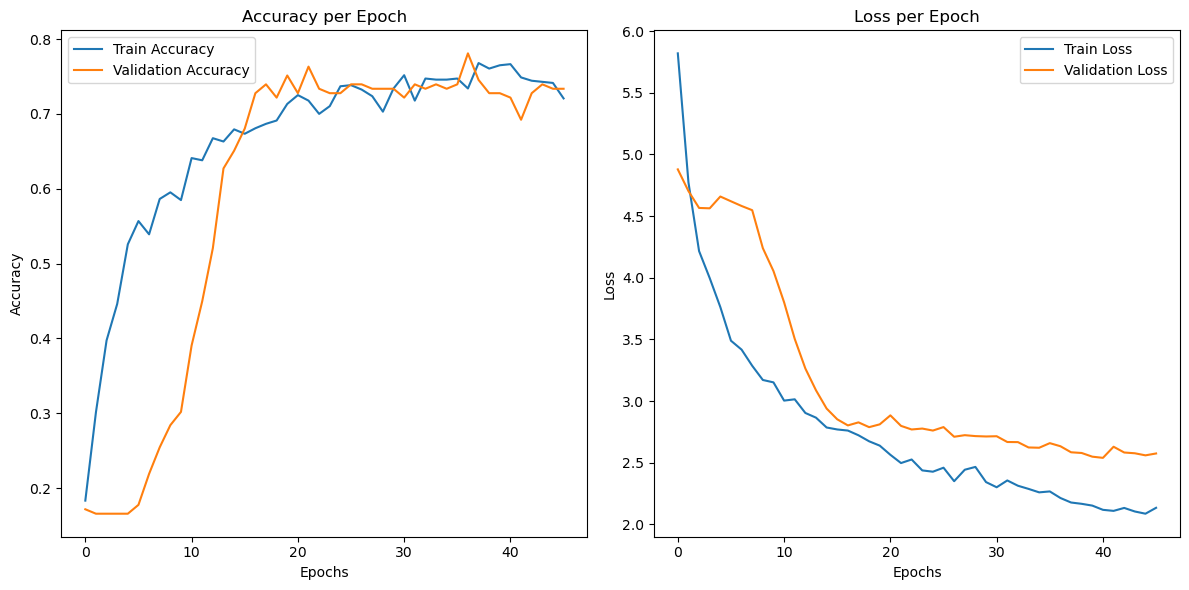

In [9]:
import matplotlib.pyplot as plt

# 학습 후 history 객체에서 정확도와 손실 값 가져오기
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 정확도 그래프
plt.figure(figsize=(12, 6))

# 정확도
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()


In [39]:
y_val_fold.shape

(169,)

6/6 [==============================] - 0s 3ms/step


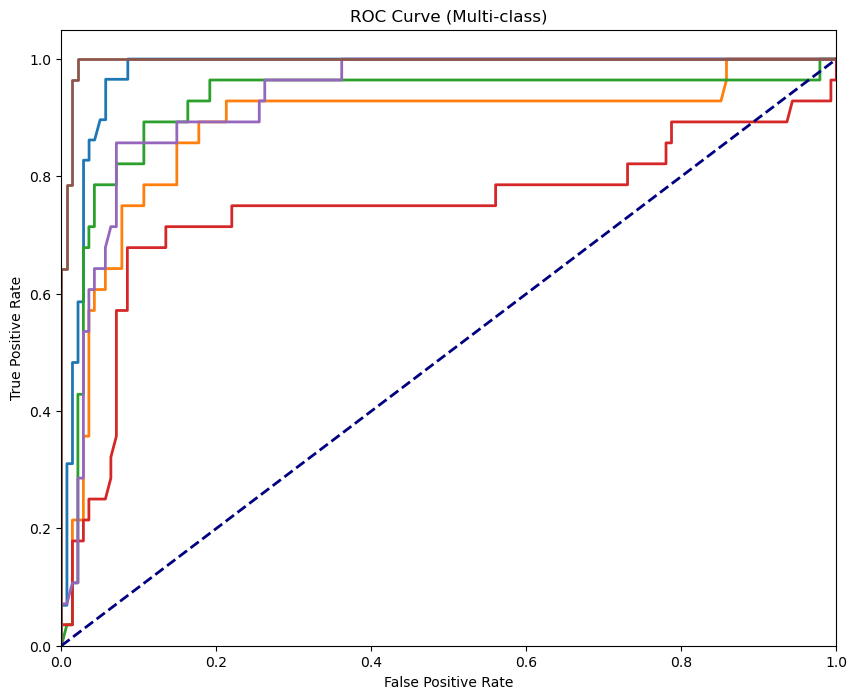

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

y_prob = model.predict(X_val_fold)  # X_val_fold는 검증 데이터

# 실제 클래스 라벨 (여기서는 이진 분류를 가정하고, 다중 클래스일 경우 y_train을 이진화)
y_true = y_val_fold  # 실제 클래스 라벨

# 클래스 수 (다중 클래스인 경우)
n_classes = 18  # 예시로 18개의 클래스를 가정

# 이진화된 클래스 라벨 (다중 클래스에서 각 클래스에 대해 ROC 곡선을 그리기 위해)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# ROC 곡선 그리기 (각 클래스별로)
fpr = dict()
tpr = dict()
roc_auc = dict()

# 각 클래스에 대해 ROC 곡선과 AUC 계산
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure(figsize=(10, 8))

# 모든 클래스의 ROC 곡선을 그리기
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2)

# 랜덤 분류선 (대각선)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 설정
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-class)')

# 그래프 표시
plt.show()

In [14]:
from tensorflow.keras.models import load_model

# 모델 로드
loaded_model = load_model('best_deep_model.keras')

# 모델 요약 보기 (선택 사항)
loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 196, 128)          768       
                                                                 
 batch_normalization_10 (Ba  (None, 196, 128)          512       
 tchNormalization)                                               
                                                                 
 dropout_15 (Dropout)        (None, 196, 128)          0         
                                                                 
 conv1d_11 (Conv1D)          (None, 189, 64)           65600     
                                                                 
 batch_normalization_11 (Ba  (None, 189, 64)           256       
 tchNormalization)                                               
                                                                 
 dropout_16 (Dropout)        (None, 189, 64)          